<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/deep-learning-from-scratch-2/Chapter8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention
+ 近年の深層学習の重要テクニックの一つ

## Attentionの仕組み
+ 注意機構(Attention Mechanism)
 + 必要な情報だけに注意を向けさせることができる。

### seq2seqの問題点
+ Encoderを使って固定長に変換しなければならないところ。
 + 固定長だと限界が低い。

### Encoderの改良
+ Encoderの出力は、入力される文章の長さに応じて、その長さを変えるべき。
+ 各時刻のLSTMレイヤの隠れ状態ベクトルを全て利用する。

### Decoderの改良1
+ Encoderは各単語に対応するLSTMレイヤの隠れ状態ベクトルをhsとして出力
 + このhsがDecoderに渡されて時系列変換が行われる
   + これまでのDecoderはEncoderのLSTMレイヤの最後にある隠れ状態だけを利用していた。

+ 入力と出力でどの単語が関連しているのかという対応関係をseq2seqに学習させることはできないか。
 + 必要な情報にだけ注意を向けさせ、その情報から時系列変換を行うことを目指す。
   + この点においてもPeekyとは違う。

+ 新たに何らかの計算を行うレイヤを追加する
 + 何らかの計算
   + 各時刻においてLSTMレイヤの隠れ状態とEncoderからのhsを受け取る
     + 必要な情報だけを選び出す
       + それをその先のAffineレイヤへと出力


+ 単語のアラインメント抽出
 + 各時刻においてDecoderへの入力単語と対応関係にある単語のベクトルをhsから選び出す
   + ただし、選び出すという操作に関して微分ができない
     + ひとつを選ぶのではなく、全てを選ぶというアプローチ
       + 各単語の重要度を表す重みを別途計算する

In [1]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

Cloning into 'deep-learning-from-scratch-2'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 386 (delta 5), reused 10 (delta 5), pack-reused 373
Receiving objects: 100% (386/386), 7.91 MiB | 5.40 MiB/s, done.
Resolving deltas: 100% (215/215), done.


In [2]:
cd deep-learning-from-scratch-2

/content/deep-learning-from-scratch-2


In [3]:
ls

ch01/  ch03/  ch05/  ch07/  common/   LICENSE.md
ch02/  ch04/  ch06/  ch08/  dataset/  README.md


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 時系列の長さ、隠れ状態ベクトルの要素数
T, H = 5, 4
hs = np.random.randn(T, H)
a = np.array([0.8, 0.1, 0.03, 0.05, 0.02])

# repeatで多次元配列を生成
ar = a.reshape(5, 1).repeat(4, axis=1)

print(hs.shape)
print(ar.shape)

(5, 4)
(5, 4)


In [5]:
hs

array([[ 1.71939546, -0.26841311, -0.68475433,  0.23784718],
       [-0.08209138,  0.96028409,  0.44949597, -0.00673877],
       [-0.612235  ,  0.76835103,  1.1587083 ,  0.72200734],
       [ 2.0682823 ,  0.39065541,  0.40748505, -1.48837174],
       [-0.8212756 ,  0.85063449, -1.2713689 ,  3.18008492]])

In [6]:
ar

array([[0.8 , 0.8 , 0.8 , 0.8 ],
       [0.1 , 0.1 , 0.1 , 0.1 ],
       [0.03, 0.03, 0.03, 0.03],
       [0.05, 0.05, 0.05, 0.05],
       [0.02, 0.02, 0.02, 0.02]])

In [0]:
# 重み付け
t = hs * ar

In [8]:
print(t.shape)

(5, 4)


In [9]:
# その重み付けしたものの和
c = np.sum(t, axis=0)
print(c.shape)

(4,)


In [10]:
c

array([ 1.43592879, -0.05910609, -0.47314574,  0.2004472 ])

In [11]:
# バッチ処理版の重み付き和の実装

# バッチの数、時系列の長さ、隠れ状態ベクトルの要素数
N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
a = np.random.randn(N, T)
ar = a.reshape(N, T, 1).repeat(H, axis=2)

t = hs * ar
print(t.shape)

# バッチごとの隠れ状態のベクトルの要素数ごとの重み付けの合計値
c = np.sum(t, axis=1)
print(c.shape)

(10, 5, 4)
(10, 4)


In [0]:
# コンテキストベクトルをもとめるWeightSumレイヤ
class WeightSum:
  def __init__(self):
    self.params, self.grads = [], []
    self.cache = None

  def forward(self, hs, a):
    N, T, H = hs.shape

    ar = a.reshape(N, T, 1).repeat(H, axis=2)
    t = hs*ar
    c = np.sum(t, axis=1)

    self.cache = (hs, ar)
    return c

  def backward(self, dc):
    hs, ar = self.cache
    N, T, H = hs.shape

    dt = dc.reshape(N, 1, H).repeat(T, axis=1) # sumの逆伝播
    dar = dt*hs
    dhs = dt*ar
    da = np.sum(dar, axis=2) # repeatの逆伝播

    return dhs, da

### Decoderの改良2
+ 各単語の重要度を表す重みaを計算したい。それをもとにコンテキストベクトルを計算できる。
 + DecoderのLSTMレイヤの隠れ状態ベクトルhが、Encoderの出力であるhsの各単語ベクトルとどれだけ似ているかを数値で表すこと。
   + 最も簡単なのはベクトルの内積を利用するもの。

$$a \cdot	b = a_1b_1 + a_2b_2 + \dots + a_nb_n $$


+ 類似度はsoftmax関数で正規化する

In [13]:
import sys
sys.path.append('..')
from common.layers import Softmax
import numpy as np

N, T, H = 10, 5, 4
hs = np.random.randn(N, T, H)
h = np.random.randn(N, H)
hr = h.reshape(N, 1, H).repeat(T, axis=1)

t = hs*hr
print(t.shape)

s = np.sum(t, axis=2)
print(s.shape)

softmax = Softmax()
a = softmax.forward(s)
print(a.shape)

(10, 5, 4)
(10, 5)
(10, 5)


In [0]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Softmax

class AttentionWeight:
  def __init__(self):
    self.params, self.grads = [], []
    self.softmax = Softmax()
    self.cache = None

  def forward(self, hs, h):
    N, T, H = hs.shape

    hr = h.reshape(N, 1, H).repeat(T, axis=1)
    t = hs*hr
    s = np.sum(t, axis=2)
    a = self.softmax.forward(s)

    self.cache = (hs, hr)
    return a

  def backward(self, da):
    hs, hr = self.cache
    N, T, H = hs.shape

    ds = self.softmax.backward(da)
    dhs = dt*hr
    dhr = dt*hs
    dh = np.sum(dhr, axis=1)

    return dhs, dh

### Decoderの改良3
+ Attention WeightレイヤとWeight Sumレイヤを組み合わせることでコンテキストベクトルを求めれるようになる。
 + Attention WeightレイヤがEncoderが出力する各単語のベクトルhsに対して注意をはらい、各単語の重みaを計算する。
  + Weight Sumレイヤがaとhsの重み付き和を求めて、コンテキストベクトルcとして出力する。

In [0]:
class Attention:
  def __init__(self):
    self.params, self.grads = [], []
    self.attention_weight_layer = AttentionWeight()
    self.weight_sum_layer = WeightSum()
    self.attention_weight = None

  def forward(self, hs, h):
    a = self.attention_weight_layer.forward(hs, h)
    out = self.weight_sum_layer.forward(hs, a)
    self.attention_weight = a
    return out

  def backward(self, dout):
    dhs0, da = self.weight_sum_layer.backward(dout)
    dhs1, dh = self.attention_weight_layer.backward(da)
    dhs = dhs0 + dhs1
    return dhs, dh

In [0]:
class TimeAttention:
  def __init__(self):
    self.params, self.grads = [], []
    self.layers = None
    self.attention_weights = None # 各Attentionレイヤの各単語への重み

  # 順伝播
  def forward(self, hs_enc, hs_dec):
    # T個分のAttentionレイヤを作成する
    N, T, H = hs_dec.shape
    out = np.empty_like(hs_dec)
    self.layers = []
    self.attention_weights = []

    for t in range(T):
      layer = Attention()
      out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
      self.layers.append(layer)
      self.attention_weights.append(layer.attention_weight)

    return out

  # 逆伝播
  def backward(self, dout):
    # T個分のAttentionレイヤを作成する
    N, T, H = dout.shape
    dhs_enc = 0
    dhs_dec = np.empty_like(dout)

    for t in range(T):
      layer = self.layers[t]
      dhs, dh = layer.backward(dout[:, t, :])
      dhs_enc += dhs
      dhs_dec[:, t, :] = dh

    return dhs_enc, dhs_dec


## Attention付きのseq2seqの実装

### Encoderの実装

In [0]:
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Encoder, Seq2seq
from ch08.attention_layer import TimeAttention

class AttentionEncoder(Encoder):
  def forward(self, xs):
    xs = self.embed.forward(xs)
    hs = self.lstm.forward(xs)
    return hs

  def backward(self, dhs):
    dout = self.lstm.backward(dhs)
    dout = self.embed.backward(dout)
    return dout

### Decoderの実装

In [0]:
class AttentionDecoder:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    embed_W = (rn(V, D) / 100).astype('f')
    lstm_Wx = (rn(D, 4*H) / np.sqrt(D) ).astype('f')
    lstm_Wh = (rn(H, 4*H) / np.sqrt(H) ).astype('f')
    lstm_b = np.zeros(4*H).astype('f')
    affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    self.embed = TimeEmbedding(embed_W)
    self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
    self.attention = TimeAttention()
    self.affine = TimeAffine(affine_W, affine_b)
    layers = [self.embed, self.lstm, self.attention, self.affine]

    self.params, self.grads = [], []
    for layer in layers:
      self.params += layer.params
      self.grads += layer.grads

  def forward(self, xs, enc_hs):
    h = enc_hs[:, -1]
    self.lstm.set_state(h)

    out = self.embed.forward(out)
    # LSTMレイヤ
    dec_hs = self.lstm.forward(out)
    # TimeAttentionレイヤ
    c = self.attention.forward(enc_hs, dec_hs)

    # TimeAttentionレイヤとLSTMレイヤの出力を結合
    out = np.concatenate((c, dec_hs), axis=2)
    score = self.affine.forward(out)

    return score

  def backward(self, dscore):
    dout = self.affine.backward(dscore)
    N, T, H2 = dout.shape
    H = H2 // 2

    dc, ddec_hs0 = dout[:, :, :H], dout[:, :, H:]
    denc_hs, ddec_hs1 = self.attention.backward(dc)
    ddec_hs = ddec_hs0 + ddec_hs1
    dout = self.lstm.dh
    denc_hs[:, -1] += dh
    self.embed.backward(dout)

    return denc_hs

  def generate(self, emc_hs, start_id, sample_size):
    sampled = []
    sample_id = start_id
    h = enc_hs[:, -1]
    self.lstm.set_state(h)

    for _ in range(sample_size):
      x = np.array([sample_id]).reshape((1, 1))

      out = self.embed.forward(x)
      dec_hs = self.lstm.forward(out)
      c = self.attention.forward(enc_hs, dec_hs)
      out = np.concatenate((c, dec_hs), axis=2)
      score = sel.affine.forward(out)

      sample_id = np.argmax(score.flatten())
      sampled.append(sample_id)
    return sampled


### seq2seqの実装

In [0]:
from ch07.seq2seq import Encoder, Seq2seq

class AttentionSeq2seq(Seq2seq):
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    args = vocab_size, wordvec_size ,hidden_size
    self.encoder = AttentionEncoder(*args)
    self.decoder = AttentionDecoder(*args)
    self.softmax = TimeSoftmaxWithLoss()

    self.params = self.encoder.params + self.decoder.params
    self.grads = self.encoder.grads + self.decoder.grads

## Attentionの評価
+ 日付フォーマットを変換する問題を扱う

### 日付フォーマットの変換問題

### Attention付きseq2seqの学習

In [0]:
import sys
sys.path.append('..')
from common.time_layers import *
from ch07.seq2seq import Seq2seq, Encoder


class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(H + D, 4 * H) / np.sqrt(H + D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H + H, V) / np.sqrt(H + H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None

    def forward(self, xs, h):
        N, T = xs.shape
        N, H = h.shape

        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N, T, H)
        out = np.concatenate((hs, out), axis=2)

        out = self.lstm.forward(out)
        out = np.concatenate((hs, out), axis=2)

        score = self.affine.forward(out)
        self.cache = H
        return score

    def backward(self, dscore):
        H = self.cache

        dout = self.affine.backward(dscore)
        dout, dhs0 = dout[:, :, H:], dout[:, :, :H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:, :, H:], dout[:, :, :H]
        self.embed.backward(dembed)

        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1)
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)

        H = h.shape[1]
        peeky_h = h.reshape(1, 1, H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1, 1))
            out = self.embed.forward(x)

            out = np.concatenate((peeky_h, out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h, out), axis=2)
            score = self.affine.forward(out)

            char_id = np.argmax(score.flatten())
            sampled.append(char_id)

        return sampled


class PeekySeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = PeekyDecoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

In [23]:
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch08.attention_seq2seq import AttentionSeq2seq
# from ch07.seq2seq import Seq2seq
# from ch07.peeky_seq2seq import PeekySeq2seq

# データの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# 入力文を反転
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
  trainer.fit(x_train, t_train, max_epoch=1,
              batch_size=batch_size, max_grad=max_grad)
  
  correct_num = 0
  for i in range(len(x_test)):
    question, correct = x_test[[i]], t_test[[i]]
    verbose = i < 10
    correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)
  
  acc = float(correct_num) / len(x_test)
  acc_list.append(acc)
  print('val acc %.3f%%' % (acc * 100))

model.save_params()

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 4.08
| epoch 1 |  iter 21 / 351 | time 13[s] | loss 3.09
| epoch 1 |  iter 41 / 351 | time 27[s] | loss 1.90
| epoch 1 |  iter 61 / 351 | time 40[s] | loss 1.72
| epoch 1 |  iter 81 / 351 | time 53[s] | loss 1.46
| epoch 1 |  iter 101 / 351 | time 67[s] | loss 1.19
| epoch 1 |  iter 121 / 351 | time 80[s] | loss 1.14
| epoch 1 |  iter 141 / 351 | time 93[s] | loss 1.09
| epoch 1 |  iter 161 / 351 | time 106[s] | loss 1.06
| epoch 1 |  iter 181 / 351 | time 119[s] | loss 1.04
| epoch 1 |  iter 201 / 351 | time 132[s] | loss 1.03
| epoch 1 |  iter 221 / 351 | time 146[s] | loss 1.02
| epoch 1 |  iter 241 / 351 | time 159[s] | loss 1.02
| epoch 1 |  iter 261 / 351 | time 172[s] | loss 1.01
| epoch 1 |  iter 281 / 351 | time 185[s] | loss 1.00
| epoch 1 |  iter 301 / 351 | time 198[s] | loss 1.00
| epoch 1 |  iter 321 / 351 | time 211[s] | loss 1.00
| epoch 1 |  iter 341 / 351 | time 224[s] | loss 1.00
Q 10/15/94                     
T 1994-10-1

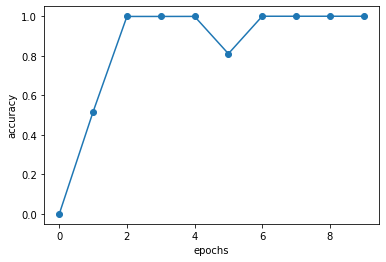

In [24]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

### Attentionの可視化

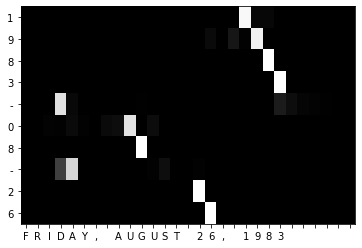

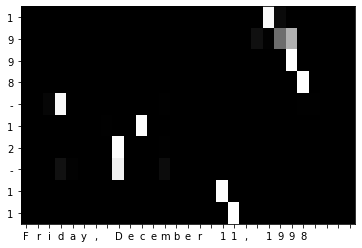

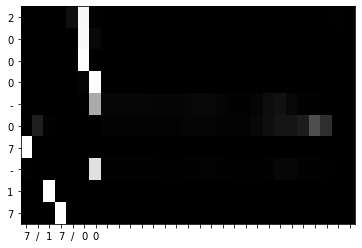

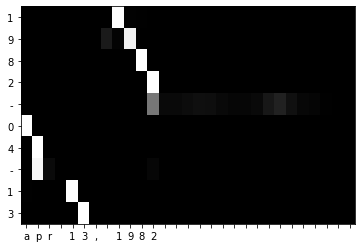

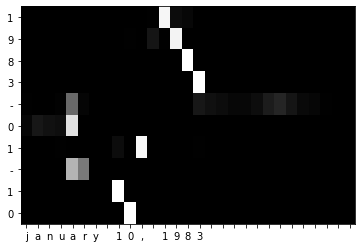

In [26]:
import sys
sys.path.append('..')
import numpy as np
from dataset import sequence
import matplotlib.pyplot as plt
from ch08.attention_seq2seq import AttentionSeq2seq

(x_train, t_train), (x_test, t_test) = sequence.load_data('date.txt')
char_to_id, id_to_char = sequence.get_vocab()

# Reverse input
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
model.load_params()

_idx = 0

def visualize(attention_map, row_labels, column_labels):
  fig, ax = plt.subplots()
  ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

  ax.patch.set_facecolor('black')
  ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
  ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
  ax.invert_yaxis()
  ax.set_xticklabels(row_labels, minor=False)
  ax.set_yticklabels(column_labels, minor=False)

  global _idx
  _idx += 1
  plt.show()

np.random.seed(1984)

for _ in range(5):
  idx = [np.random.randint(0, len(x_test))]
  x = x_test[idx]
  t = t_test[idx]

  model.forward(x, t)
  d = model.decoder.attention.attention_weights
  d = np.array(d)
  attention_map = d.reshape(d.shape[0], d.shape[2])

  # reverse for print
  attention_map = attention_map[:, ::-1]
  x = x[:, ::-1]

  row_labels = [id_to_char[i] for i in x[0]]
  column_labels = [id_to_char[i] for i in t[0]]
  column_labels = column_labels[1:]

  visualize(attention_map, row_labels, column_labels)

## Attentionに関する残りのテーマ

### 双方向RNN
+ 文章を左から右に読むだけでなく、右から左に読むなどもしたい。

+ 双方向LSTMはこれまでのLSTMレイヤに加えて、逆方向に処理するLSTMレイヤも追加する
  + 各時刻において2つのLSTMレイヤの隠れ状態を連結し、それを最終的な隠れ状態ベクトルとする
  + 双方向から処理することで、各単語に対応する隠れ状態ベクトルは左と右の両方向から情報を集約することができる。

+ 実装方法
 + 一つのLSTMレイヤはこれまで通りの入力文を与える（左から右方向）
 + もう一つのLSTMレイヤには入力文を右から左方向に並べ替えたものを与える。
 + これら二つのLSTMレイヤの出力を連結すれば双方向LSTMレイヤができる。

### Attentionレイヤの使用方法
+ Attentionレイヤをどこに置くかで精度が変わるが、やってみないとわからない。
 + AttentionレイヤをLSTMレイヤとAffineレイヤの間に入れるケース
 + 次時刻のLSTMレイヤとの間に入れるケース

### seq2seqの深層化とskipコネクション
+ 深層化
 + 層を重ねることで、表現力の高いモデルを作ることができる。
   + 層を重ねた場合、複数のレイヤにAttentionレイヤによるコンテキストベクトルを渡していく。
+ skipコネクション
 + 層をまたいで線を繋ぐ（加算）というシンプルなテクニック
   + 逆伝播時には勾配をそのまま流すだけになる。勾配が消失あるいは爆発しない。

## Attentionの応用

### Google Neural Machine Translation(GNMT)
+ LSTMレイヤの多層化
+ skipコネクション
+ 複数GPUでの分散学習

### Transformer
+ RNNの欠点は並列化処理
 + 前の時間に計算した結果を使って逐次的に計算するため、時間方向で並列化することはできない。
 + RNNを使わないようにする研究があるらしい。
  + 代わりにCNNを使ったり、Attentionを使ったり


+ TransformerはAttentionによって構成される。
 + Self-Attention（自分自身に対してのAttention）
  + ひとつの時系列データ内において各要素が他の要素に対してどのような関連性があるのかを見ていこうというもの。
 + 計算量を抑え、GPUによる並列計算の恩恵をより多くうけることができる。